# Assignment 1 (part I): Line Fitting

## Problem 1
### Prove that affine transformations preserve parallel lines.

Solution:  
Let $l_1 : \vec{p} + t\vec{u}$ and $l_2 : \vec{q} + t\vec{v}$, $t \in R$, are parallel lines.  
($\vec{p}$ and $\vec{q}$ are points on the line, $\vec{u}$ and $\vec{v}$ are directions of the line, t is the parameter that specified the length of the line.)  
Then $\vec{u} = k\vec{v}$, $k \in R$ since they are parallel.  
Affine transformations can be rewrite as $f(\vec{x}) = \textbf{A}\vec{x} + \vec{b}$, where $\textbf{A}$ is linear 2D transformations and  $\vec{b}$ is translation.  
Now we can show:  
  
$f(l_1) = \textbf{A}l_1 + \vec{b} = \textbf{A}(\vec{p} + t\vec{u}) + \vec{b} = (\textbf{A}\vec{p} + \vec{b}) + t(\textbf{A}\vec{u}) = \vec{p'} + t\vec{u'}$  
$f(l_2) = \textbf{A}l_2 + \vec{b} = \textbf{A}(\vec{q} + tk\vec{u}) + \vec{b} = (\textbf{A}\vec{q} + \vec{b}) + tk(\textbf{A}\vec{u}) = \vec{q'} + tk\vec{u'}$ 
  
Clearly, the 2 line after affine transformation both have same direction $\vec{u'}$, thus parallelism is preserved.

## Problem 2 (least-squares)
### Complete implementation of function $estimate$ of class $LeastSquareLine$ below. It should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. You can use either SVD of matrix $A$ or inverse of matrix $A^T A$, as discussed in class. NOTE: several cells below test your code.

In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import ransac

In [2]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D):
        B = points2D[:,1] # y_hat
        A = np.copy(points2D)
        A[:,1] = 1.0 # X with offset = 1
        
        U, W, V = la.svd(A, full_matrices=False)
        A_inv = np.matmul(np.matmul(V.T, la.inv(np.diag(W))), U.T)
        
        x = np.dot(A_inv, B)

        # Vector B and matrix A are already defined. Change code below
        self.a = x[0]
        self.b = x[1]
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

## Problem 3 (RANSAC for robust line fitting, single model)

#### Working code below generates a noisy cloud of points in ${\cal R}^2$ from a given line and a group of outliers.

<IPython.core.display.Javascript object>


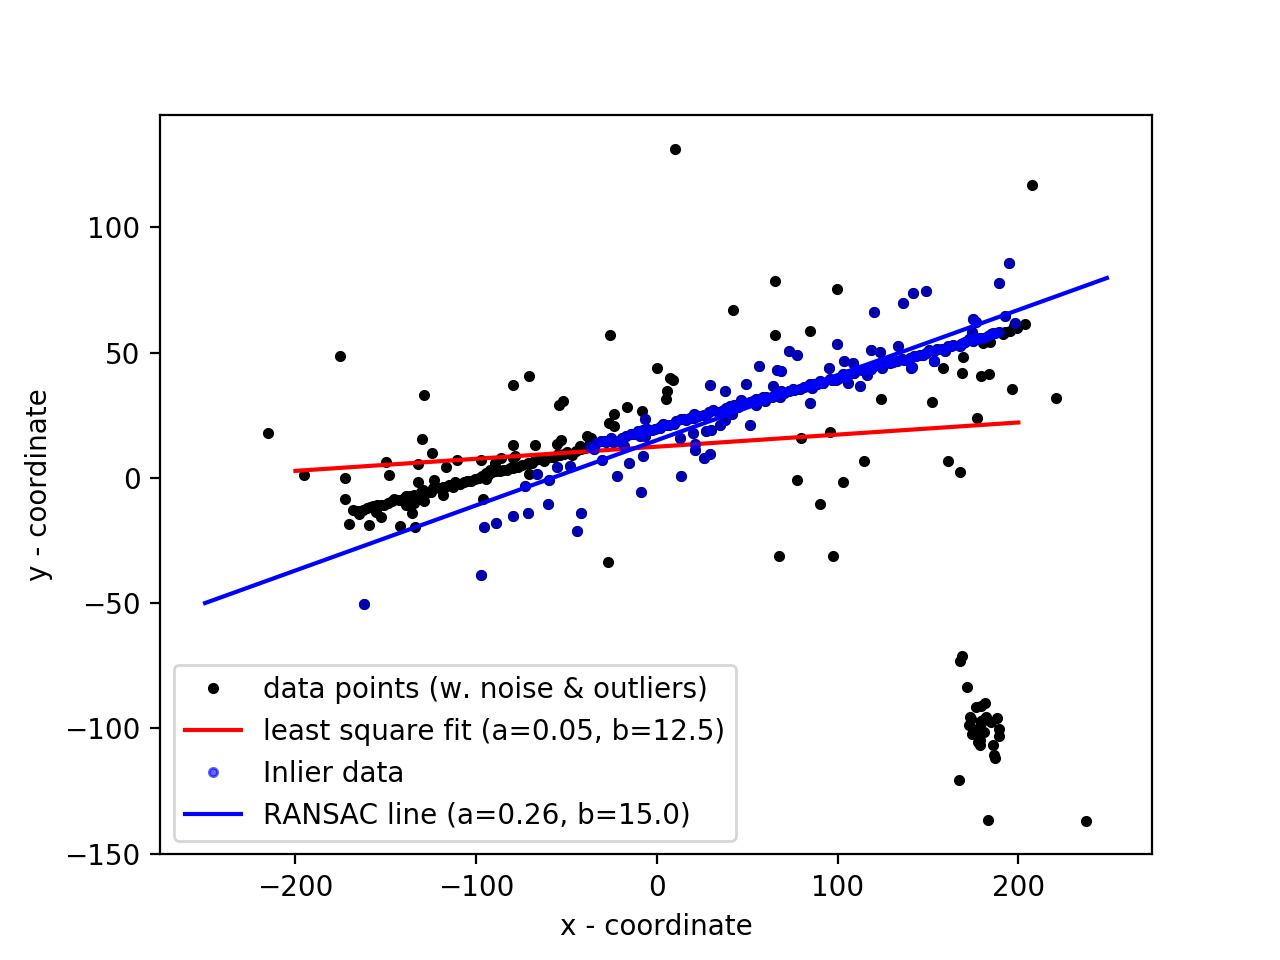

In [3]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate the "true" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 0.5 * noise
data[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

#### Code below uses your implementation of class $LeastSquareLine$ for least-square line fitting for the data above. The estimated line is displayed in the cell above. Use this cell to test your code in Problem 2. Of course, your least-square line will be affected by the outliers.

In [4]:
LSline = LeastSquareLine() # uses class implemented in Problem 2
print LSline.estimate(data)
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

True


### (part a) Assume that a set of $N=100$ points in $2D$ includes $N_i=20$ inliers for one line and $N_o=80$ outliers. What is the least number of times one should sample a random pair of points from the set to get probability $p\geq 0.95$ that in at least one of the sampled pairs both points are inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution:  
$p = 0.95$  
$p_i = \frac{20}{100} = 0.2$, which is the prob. that random choice of 1 pts is inlier.  
$w = \frac{20}{100}\frac{19}{99} = 0.0384$, which is the prob that a pair of pts are inliers.  
Let $k$ be number of times we should sample.  
$1 - p = (1 - w)^k$, which represent the prob. that in k times, we never get a pair of inliers.
  
Therefore, $k = \frac{\log{(1-p)}}{\log{(1-w)}}$, is the general formula.  
  
Plug in $p = 0.95$ and $w = 0.0384$ will give us result $76.539 \approx 77$ times.

### (part b) Using the knowledge of the number of inliers/outliers in the example at the beginning of Problem 3, estimate the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. Use your formula in part (a). Show your numbers in the cell below. Then, use your estimate as a value of parameter $max\text{_}trials$  inside function $ransac$ in the code cell below and test it.  You should also change $residual\text{_}threshold$ according to the noise level for inliers in the example. NOTE: the result is displayed in the same figure at the beginning of Problem 3.

Your estimates:  
$N = 400$, $N_o = 30$ according to problem 3  
  
$k = \frac{\log{(1-0.95)}}{\log{(1-(\frac{370}{400}\frac{369}{399}))}}$  
  
$k = \frac{\log{(0.05)}}{\log{(0.1445488)}}$
$k = 1.549 \approx 2$  
  
max_trials = 2   
residual_threshold = 20, according to noise level = 5 or 20 in problem 3's code.

In [5]:
# robustly fit line using RANSAC algorithm
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=20, max_trials=2)
a_rs, b_rs = model_robust.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

## Problem 4 (sequential RANSAC for robust multi-line fitting)

#### Generating noisy data with outliers

<IPython.core.display.Javascript object>


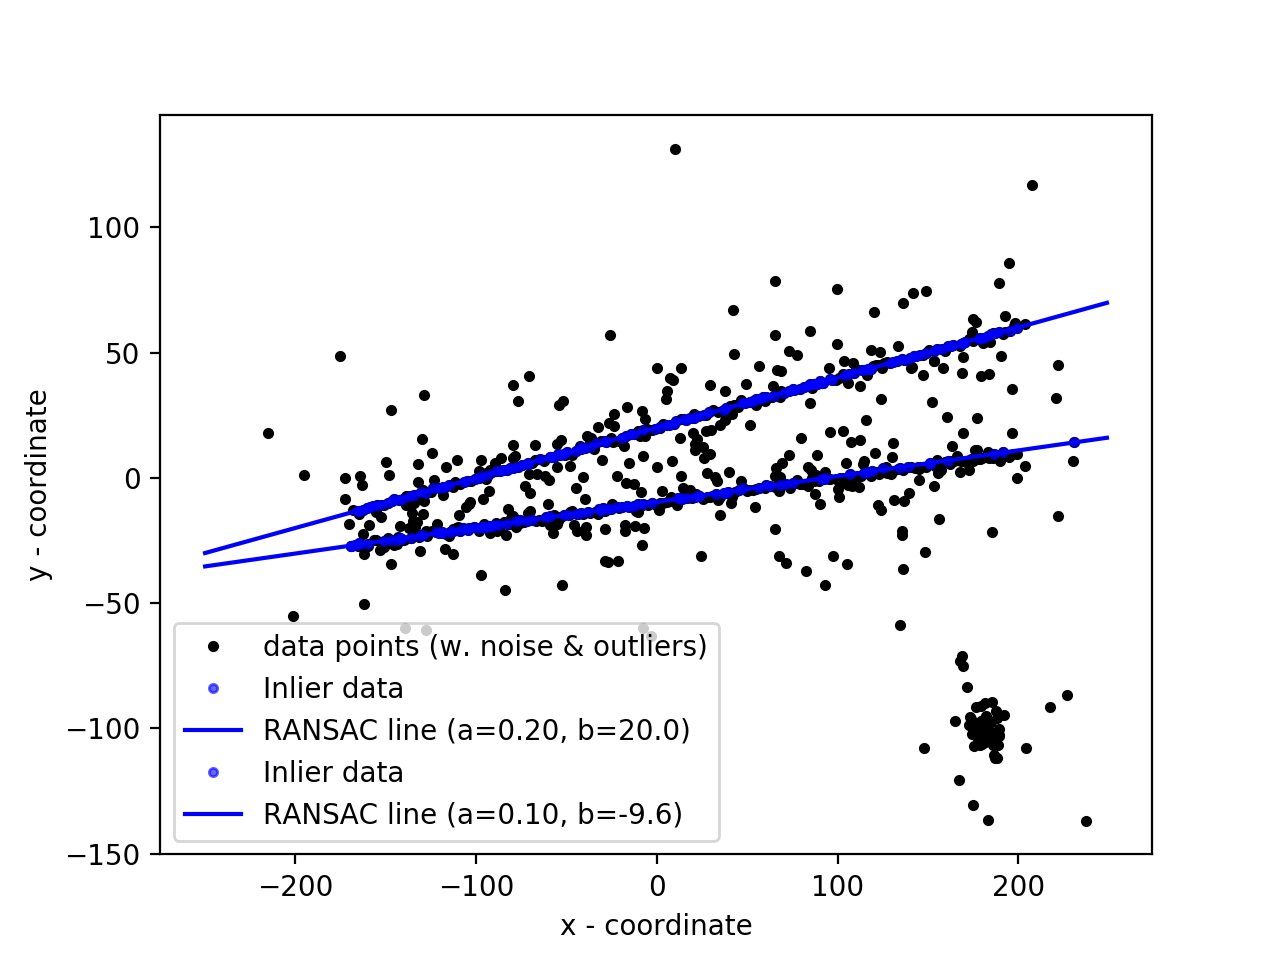

In [6]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate the "true" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data2[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 0.5 * noise
data2[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

data = np.concatenate((data,data2)) # combining with previous data

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### Write code below using sequential RANSAC to detect two lines in the data above. Your lines should be displayed in the figure above.

In [7]:
# robustly fit line using RANSAC algorithm
model_robust1, inliers1 = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=0.5, max_trials=50)
a_rs, b_rs = model_robust1.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust1.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers1, 0], data[inliers1, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

In [8]:
# remove inliers in line1
data = np.array([data[i] for i in range(data.shape[0]) if inliers1[i] == False])
print data.shape

(665, 2)


In [9]:
# robustly fit line using RANSAC algorithm
model_robust2, inliers2 = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=0.5, max_trials=50)
a_rs, b_rs = model_robust2.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust2.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers2, 0], data[inliers2, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()